In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle as pickle
from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
import glob
import random

import datetime
off=0


2023-01-20 18:21:02.807304: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 18:21:02.974781: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 18:21:02.974818: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 18:21:04.303885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import tensorflow_io as tfio


In [96]:
directory = "/gws/nopw/j04/aopp/manshausen/bing_dl/train/"

In [92]:
# def load_data_using_tfdata(folders):
#     """
#     Load the images in batches using Tensorflow (tfdata).
#     Cache can be used to speed up the process.
#     Faster method in comparison to image loading using Keras.
#     Returns:
#     Data Generator to be used while training the model.
#     """
#     def parse_image(file_path):
#         # convert the path to a list of path components
#         parts = tf.strings.split(file_path, os.path.sep)
#         class_names = np.array(os.listdir(dir_path + '/train'))
#         # The second to last is the class-directory
#         label = parts[-2] == class_names
#         # load the raw data from the file as a string
#         img = tf.io.read_file(file_path)
#         # convert the compressed string to a 3D uint8 tensor
#         img = tfio.experimental.image.decode_tiff(img, channels=3)
#         # Use `convert_image_dtype` to convert to floats in the [0,1] range
#         img = tf.image.convert_image_dtype(img, tf.float32)
#         # resize the image to the desired size.
#         img = tf.image.resize(img, [img_dims[0], img_dims[1]])
#         return img, label

#     def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
#         # If a small dataset, only load it once, and keep it in memory.
#         # use `.cache(filename)` to cache preprocessing work for datasets
#         # that don't fit in memory.
#         if cache:
#             if isinstance(cache, str):
#                 ds = ds.cache(cache)
#             else:
#                 ds = ds.cache()
#         ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#         # Repeat forever
#         ds = ds.repeat()
#         ds = ds.batch(batch_size)
#         # `prefetch` lets the dataset fetch batches in the background
#         # while the model is training.
#         ds = ds.prefetch(buffer_size=AUTOTUNE)
#         return ds

#     data_generator = {}
#     for x in folders:
#         dir_extend = dir_path + '/' + x
#         list_ds = tf.data.Dataset.list_files(str(dir_extend+'/*/*'))
#         AUTOTUNE = tf.data.experimental.AUTOTUNE
#         # Set `num_parallel_calls` so that multiple images are
#         # processed in parallel
#         labeled_ds = list_ds.map(
#             parse_image, num_parallel_calls=AUTOTUNE)
#         # cache = True, False, './file_name'
#         # If the dataset doesn't fit in memory use a cache file,
#         # eg. cache='./data.tfcache'
#         data_generator[x] = prepare_for_training(
#             labeled_ds, cache='./data.tfcache')

#     return data_generator

In [93]:
# # Need to change this w.r.t data
# dir_path = directory
# folders = ['patches']
# load_data_using = 'tfdata'

# batch_size = 32
# img_dims = [256, 256]

# data_generator = load_data_using_tfdata(folders)


In [91]:
data_generator

NameError: name 'data_generator' is not defined

In [97]:
from pathlib import Path
from PIL import Image

height = width = 1400 

def read_pil_image(img_path, height, width):
        with open(img_path, 'rb') as f:
            return np.array(Image.open(f).convert('RGB').resize((width, height)))

def load_all_images(dataset_path, height, width, img_ext='tif'):
    return np.array([read_pil_image(str(p), height, width) for p in 
                                    glob.glob(dataset_path+"*."+img_ext)[::200]]) 


In [205]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                rescale = 1./255,
                                shear_range=0.2,
                                zoom_range=[0.7,0.9],
                                rotation_range=30,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                fill_mode='wrap',
                                horizontal_flip=True,
                                featurewise_center=True,
                                featurewise_std_normalization=True,
                                validation_split=0.50,
    
                                # preprocessing_function= tf.keras.applications.resnet_v2.preprocess_input
)



In [179]:
# load_all_images('/gws/nopw/j04/aopp/manshausen/bing_dl/patches/*/',height, width)

In [180]:
# for p in glob.glob("/gws/nopw/j04/aopp/manshausen/bing_dl/patches/*/*."+'tif')[::20]:
#     print(read_pil_image(str(p), height, width))

In [100]:
train_datagen.fit(load_all_images( "/gws/nopw/j04/aopp/manshausen/bing_dl/train/patches/*/", height, width))

In [206]:
train_image_generator = train_datagen.flow_from_directory(
    directory,
    batch_size=10,
    # color_mode="grayscale",
    target_size=(400, 400),
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=True,
)
val_image_generator = train_datagen.flow_from_directory(
    directory,
    batch_size=10,
    # color_mode="grayscale",
    target_size=(400, 400),
    class_mode='categorical',
    subset='validation',
    seed=42,
    shuffle=True,
)

Found 4174 images belonging to 2 classes.
Found 4174 images belonging to 2 classes.


In [106]:
train_image_generator.batch_size

10

In [107]:
train_image_generator.next()[0].shape

/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/users/pete_nut/miniconda3/envs/sentinelind/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(10, 400, 400, 3)

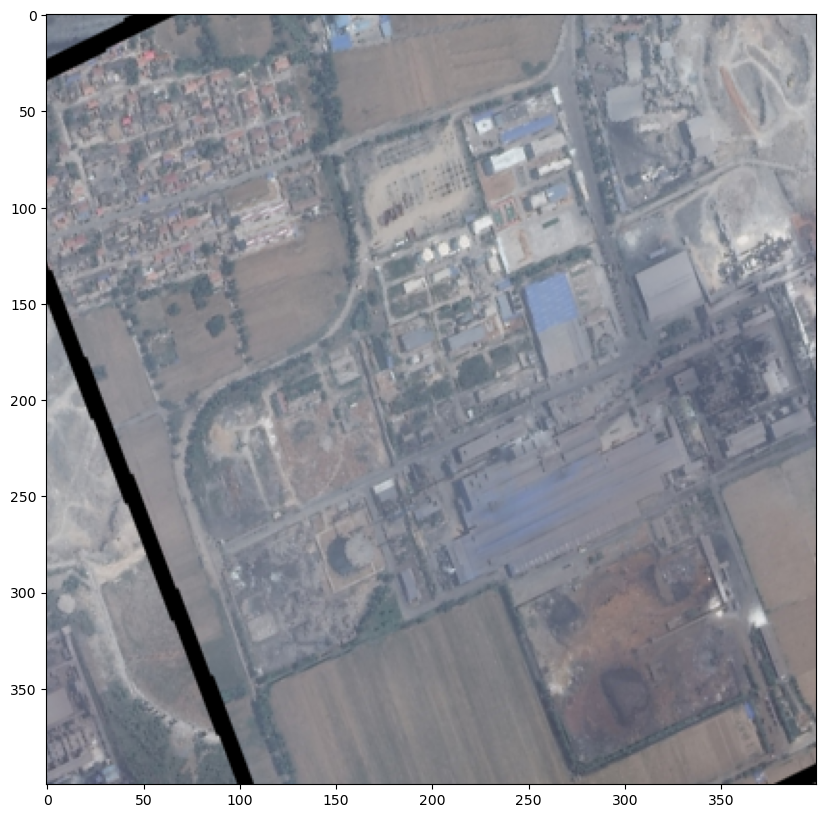

In [212]:
plt.figure(figsize=(10,10))
plt.imshow(train_image_generator.next()[0][0])

In [35]:
train_image_generator.next()

(array([[[[0.5585938 , 0.5885898 , 0.67048156],
          [0.49381182, 0.52102584, 0.59588414],
          [0.56786376, 0.58888173, 0.66612446],
          ...,
          [0.57416046, 0.5903737 , 0.6733255 ],
          [0.5893493 , 0.6115363 , 0.69262534],
          [0.5257919 , 0.556218  , 0.6369605 ]],
 
         [[0.67068714, 0.6800736 , 0.76145655],
          [0.585198  , 0.6046384 , 0.6793153 ],
          [0.59928507, 0.6256242 , 0.69035023],
          ...,
          [0.49021158, 0.5012459 , 0.5799543 ],
          [0.5113123 , 0.528049  , 0.5953141 ],
          [0.5132221 , 0.53413683, 0.597445  ]],
 
         [[0.70635253, 0.7336492 , 0.80485475],
          [0.6767645 , 0.70407116, 0.7752367 ],
          [0.6589433 , 0.6862599 , 0.75738555],
          ...,
          [0.3908266 , 0.41522533, 0.49862966],
          [0.38283533, 0.4149201 , 0.4835331 ],
          [0.39548728, 0.42216653, 0.49661255]],
 
         ...,
 
         [[0.39831176, 0.42007187, 0.5111625 ],
          [0.40058

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
!kill 25962

In [11]:
%tensorboard --logdir='~/sentinel_industry/bingmaps/'

Reusing TensorBoard on port 6006 (pid 47282), started 17:13:58 ago. (Use '!kill 47282' to kill it.)

In [14]:
import tensorflow.keras.layers as layers

model = tf.keras.Sequential([
    tf.keras.applications.resnet_v2.ResNet50V2(
    #
    # resize_rescale_augment,
    # layers.Conv2D(3, 5, padding='same', activation='tanh'), # this seems like a bit of a brute force approach to handing a 3 channel image to resnet, 
                                                            # maybe try changing the source so it accepts 4 channels?
    
        include_top=True,
        weights=None, # if I don't use the pre trained weights from image net, does it matter that i don't use the preprocessing step which reorders RGB to BGR and zero-centers wrt imagenet?
        input_shape=(256, 256, 3),
        # pooling=max ,
        classes=3,),
    # layers.Flatten(), # does this make sense? or is there another way to get down to just three output dimensions?
    # layers.Dense(3)
])

log_dir = '/home/users/pete_nut/sentinel_industry/bingmaps/logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch = '120,140')

# def scheduler(epoch, lr):
#     if epoch < 30:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.03)
    
# lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50,verbose=1, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.build(input_shape=(256, 256, 3))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 3)                 23570947  
Total params: 23,570,947
Trainable params: 23,525,507
Non-trainable params: 45,440
_________________________________________________________________


2023-01-12 09:31:54.572240: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-01-12 09:31:54.572282: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-01-12 09:31:54.572402: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [13]:
# now with normalisation
model.fit(
        train_image_generator,
        # workers=4, 
        use_multiprocessing=False,
        steps_per_epoch=2,
        epochs=2,
        validation_data=val_image_generator,
        validation_steps=2,
        callbacks=[tensorboard_callback,es_callback]
)
# model.save_weights('/gws/nopw/j04/aopp/manshausen/bing_1sthalf.h5')  # always save your weights after training or during training


Epoch 1/2
2/2 [==============================] - 12s 6s/step - loss: 10.8763 - categorical_accuracy: 0.3667 - val_loss: 6.0234 - val_categorical_accuracy: 0.4000
Epoch 2/2
2/2 [==============================] - 6s 4s/step - loss: 41.7629 - categorical_accuracy: 0.4000 - val_loss: 20.7158 - val_categorical_accuracy: 0.2500


In [11]:
import keras_tuner
from keras_tuner.applications import HyperResNet

hypermodel = HyperResNet(input_shape=(256, 256, 3), classes=3)

tuner = keras_tuner.RandomSearch(
    hypermodel,
    objective="val_accuracy",
    max_trials=2,
    overwrite=True,
    directory="my_dir",
    project_name="built_in_hypermodel",
)

tuner.search(
    train_image_generator, epochs=1, validation_data=val_image_generator
)

2023-01-09 15:02:51.103867: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-09 15:02:51.110655: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-09 15:02:51.110670: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 15:02:51.110699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (host596.jc.rl.ac.uk): /proc/driver/nvidia/version does not exist
2023-01-09 15:02:51.111287: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebui


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
next              |?                 |version
8                 |?                 |conv3_depth
36                |?                 |conv4_depth
max               |?                 |pooling
adam              |?                 |optimizer
0.001             |?                 |learning_rate



2023-01-09 15:02:57.237665: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-09 15:02:57.238211: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2794840000 Hz


 11/401 [..............................] - ETA: 38:17 - loss: 15.9614 - accuracy: 0.4168

KeyboardInterrupt: 

In [11]:
model.load_weights('/gws/nopw/j04/aopp/manshausen/bing_2ndhalf2es.h5')

In [12]:
model

In [13]:
val_image_generator = train_datagen.flow_from_directory(
    directory,
    batch_size=20,
    # color_mode="grayscale",
    # target_size=(400, 400),
    class_mode='categorical',
    subset='training',
    seed=42,
    shuffle=False,
)

Found 4106 images belonging to 3 classes.


In [14]:
train_image_generator.filenames

['coal/G107290_17_1m_utm.tif',
 'coal/G107296_17_1m_utm.tif',
 'coal/G107306_17_1m_utm.tif',
 'coal/G107312_17_1m_utm.tif',
 'coal/G107339_17_1m_utm.tif',
 'coal/G107340_17_1m_utm.tif',
 'coal/G107341_17_1m_utm.tif',
 'coal/G107349_17_1m_utm.tif',
 'coal/G107351_17_1m_utm.tif',
 'coal/G107352_17_1m_utm.tif',
 'coal/G107353_17_1m_utm.tif',
 'coal/G107366_17_1m_utm.tif',
 'coal/G107378_17_1m_utm.tif',
 'coal/G107380_17_1m_utm.tif',
 'coal/G107382_17_1m_utm.tif',
 'coal/G107384_17_1m_utm.tif',
 'coal/G107387_17_1m_utm.tif',
 'coal/G107397_17_1m_utm.tif',
 'coal/G107404_17_1m_utm.tif',
 'coal/G107406_17_1m_utm.tif',
 'coal/G107410_17_1m_utm.tif',
 'coal/G107414_17_1m_utm.tif',
 'coal/G107428_17_1m_utm.tif',
 'coal/G107433_17_1m_utm.tif',
 'coal/G107438_17_1m_utm.tif',
 'coal/G107444_17_1m_utm.tif',
 'coal/G107449_17_1m_utm.tif',
 'coal/G107453_17_1m_utm.tif',
 'coal/G107458_17_1m_utm.tif',
 'coal/G107462_17_1m_utm.tif',
 'coal/G107464_17_1m_utm.tif',
 'coal/G107474_17_1m_utm.tif',
 'coal/G

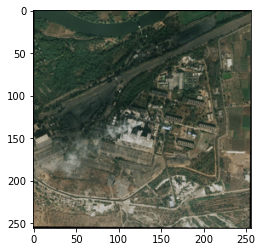

In [15]:
plt.imshow(read_pil_image('/gws/nopw/j04/aopp/manshausen/bing_dl/patches/'+ val_image_generator.filenames[0], width, height), )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


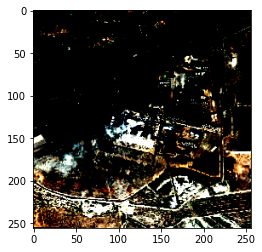

In [16]:
plt.imshow(val_image_generator.next()[0][0])

In [110]:
val_image_generator.filenames

['coal/G100001_17_1m_utm.tif',
 'coal/G100004_17_1m_utm.tif',
 'coal/G100014_17_1m_utm.tif',
 'coal/G100034_17_1m_utm.tif',
 'coal/G100040_17_1m_utm.tif',
 'coal/G100041_17_1m_utm.tif',
 'coal/G100055_17_1m_utm.tif',
 'coal/G100057_17_1m_utm.tif',
 'coal/G100059_17_1m_utm.tif',
 'coal/G100063_17_1m_utm.tif',
 'coal/G100067_17_1m_utm.tif',
 'coal/G100071_17_1m_utm.tif',
 'coal/G100077_17_1m_utm.tif',
 'coal/G100086_17_1m_utm.tif',
 'coal/G100091_17_1m_utm.tif',
 'coal/G100094_17_1m_utm.tif',
 'coal/G100098_17_1m_utm.tif',
 'coal/G100100_17_1m_utm.tif',
 'coal/G100108_17_1m_utm.tif',
 'coal/G100114_17_1m_utm.tif',
 'coal/G100123_17_1m_utm.tif',
 'coal/G100130_17_1m_utm.tif',
 'coal/G100133_17_1m_utm.tif',
 'coal/G100137_17_1m_utm.tif',
 'coal/G100142_17_1m_utm.tif',
 'coal/G100149_17_1m_utm.tif',
 'coal/G100154_17_1m_utm.tif',
 'coal/G100157_17_1m_utm.tif',
 'coal/G100163_17_1m_utm.tif',
 'coal/G100166_17_1m_utm.tif',
 'coal/G100180_17_1m_utm.tif',
 'coal/G100182_17_1m_utm.tif',
 'coal/G

In [29]:
val_image_generator.next()

In [17]:
pre = model.predict(val_image_generator, verbose=2
                   )

2023-01-06 15:06:37.631962: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-06 15:06:37.632828: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2794840000 Hz


206/206 - 536s


In [18]:
pred = tf.nn.softmax(pre)

In [21]:
pred.numpy()

array([[0.8232854 , 0.00729855, 0.16941606],
       [0.91970307, 0.00284677, 0.07745025],
       [0.25511917, 0.38170022, 0.3631806 ],
       ...,
       [0.00616978, 0.92105806, 0.07277211],
       [0.03522787, 0.86425406, 0.10051811],
       [0.25041226, 0.07813877, 0.67144895]], dtype=float32)

In [58]:
from cleanlab.filter import find_label_issues

ordered_label_issues = find_label_issues(
    labels = val_image_generator.labels,
    pred_probs=pred.numpy(),
    return_indices_ranked_by='self_confidence',
)

In [350]:
len(ordered_label_issues)

917

In [60]:
np.save('labelnogood2', ordered_label_issues, )

In [25]:
i=0

In [62]:
all_ordered_label_issues=ordered_label_issues

In [63]:
ordered_label_issues=ordered_label_issues[0:1000]

In [64]:
ordered_label_issues.sort()

In [1235]:
discard_list = list()
i=0

In [1233]:
i=i-2

coal/G107715_17_1m_utm.tif


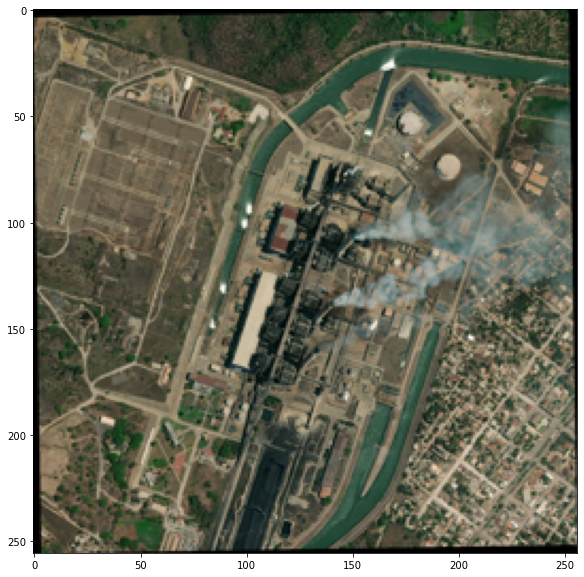

In [1268]:
index = ordered_label_issues[i]
i=i+1
file = val_image_generator.filenames[index]
plt.figure(figsize=(10, 10))
plt.imshow(read_pil_image('/gws/nopw/j04/aopp/manshausen/bing_dl/patches/'+ file, width, height), )
print(file)


In [1259]:
pred[index]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.12753966, 0.78032726, 0.0921331 ], dtype=float32)>

In [1237]:
discard_list.append('/gws/nopw/j04/aopp/manshausen/bing_dl/patches/'+val_image_generator.filenames[index])

In [399]:
# discard_list.pop()

'/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G112673_17_1m_utm.tif'

In [496]:
discard_list

['/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107353_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107382_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107514_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107623_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107667_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107740_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107910_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107915_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107963_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107980_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107992_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G107996_17_1m_utm.tif',
 '/gws/nopw/j04/aopp/manshausen/bing_dl/patches/coal/G108027_17_1m_utm.tif',

In [1231]:
for file in discard_list:
    newdir = file[0:38]+'discarded_patches/'+file.split('/')[-1]
    os.rename(file, newdir)
    # print(file[0:38]+'discarded_patches/'+file.split('/')[-1])

In [56]:
# def get_indices_from_keras_generator(gen, batch_size):
#     """
#     Given a keras data generator, it returns the indices and the filepaths
#     corresponding the current batch. 
#     :param gen: keras generator.
#     :param batch_size: size of the last batch generated.
#     :return: tuple with indices and filenames
#     """

#     idx_left = (gen.batch_index - 1) * batch_size
#     idx_right = idx_left + gen.batch_size if idx_left >= 0 else None
#     indices = gen.index_array[idx_left:idx_right]
#     filenames = [gen.filenames[i] for i in indices]
#     return indices, filenames